### Step5: cell type clustering using marker genes

for the cropped cells in step4, sum sc marker gene counts, do cell type clustering\
considering three types, 0-npc, 1-pc, 2-pp

In [1]:
import numpy as np
import pandas as pd 
from collections import defaultdict
import pickle
import timeit
import matplotlib.pyplot as plt
import matplotlib.colors as colors

### Step5.1: prepare data for cell typing

#### Load cropped data

In [2]:
##### healthy/TD tile lists
tileList = [2102, 2103, 2104, 2105, 2106, 2107, 2116, 2117, 2118, 2119]
tileList_H = [2102, 2103, 2104, 2105, 2106, 2107]
tileList_TD = [2116, 2117, 2118, 2119]

##### read healthy tiles expression data
H_dict = {}
for t in tileList_H:
    outfile = 'output_step4/crop_tile'+str(t)+'.pkl'
    with open(outfile, 'rb') as f:
        pickle_dict = pickle.load(f)
        df_seg_t = pickle_dict['df_seg_'+str(t)]
    H_dict['df'+str(t)] = df_seg_t
print(H_dict.keys())

##### read TD tiles expression data
TD_dict = {}
for t in tileList_TD:
    outfile = 'output_step4/crop_tile'+str(t)+'.pkl'
    with open(outfile, 'rb') as f:
        pickle_dict = pickle.load(f)
        df_seg_t = pickle_dict['df_seg_'+str(t)]
    TD_dict['df'+str(t)] = df_seg_t
print(TD_dict.keys())

dict_keys(['df2102', 'df2103', 'df2104', 'df2105', 'df2106', 'df2107'])
dict_keys(['df2116', 'df2117', 'df2118', 'df2119'])


In [3]:
##### combine dfs of healthy and tiles
frames = [H_dict['df2102'], H_dict['df2103'], H_dict['df2104'], H_dict['df2105'], H_dict['df2106'], H_dict['df2107'],
          TD_dict['df2116'], TD_dict['df2117'], TD_dict['df2118'], TD_dict['df2119']]
df = pd.concat(frames)
print("#tiles", df.tile.nunique())

##### remove cells without a center
print(df.cell.nunique())
df = df[df.centerX>0]
print(df.cell.nunique())

#tiles 10
3347
926


#### Compute sc total umi for each gene, read depth/size factor, and sc x/y range

In [4]:
##### compute sc total umi for each gene
# [tile, cell, gene, sc_umi]
sc_umi = []
##### also compute sc all gene total count, xrange, and yrange
# [tile, cell, sc_total, sc_xmin, sc_xmax, sc_xrange, sc_ymin, sc_ymax, sc_yrange]
sc_range = []

start = timeit.default_timer()

# groupby tile
df_gbT = df.groupby('tile')

for t in tileList:
    print('t =', t)
    
    df_t = df_gbT.get_group(t)

    # groupby cell
    df_t_gbC = df_t.groupby('cell')
    # unique cells
    cell_t = df_t.cell.unique().tolist()

    for c in cell_t:
        df_t_c = df_t_gbC.get_group(c)

        # sc_range append
        sc_range.append([t, c,
                         df_t_c.umi.sum(),
                         df_t_c.x.min(), df_t_c.x.max(), df_t_c.x.max()-df_t_c.x.min(), 
                         df_t_c.y.min(), df_t_c.y.max(), df_t_c.y.max()-df_t_c.y.min()])

        # groupby gene
        df_t_c_gbG = df_t_c.groupby('geneID')
        # unique genes
        gene_c = df_t_c.geneID.unique().tolist()

        for g in gene_c:
            df_t_c_g = df_t_c_gbG.get_group(g)
            # sc_umi append
            sc_umi.append([t, c, g, 
                           df_t_c_g.umi.sum()])

stop = timeit.default_timer()
print('Time: ', stop - start) # ~8min

t = 2102
t = 2103
t = 2104
t = 2105
t = 2106
t = 2107
t = 2116
t = 2117
t = 2118
t = 2119
Time:  252.4442382492125


In [5]:
##### add to df
data = tuple([tuple(row) for row in np.array((df.tile.tolist(), df.cell.tolist())).T])
keys = tuple([tuple(row) for row in np.array(sc_range)[:,:2]])
vals = np.array(sc_range)[:,2:].tolist()
memo = defaultdict(lambda: (0, 0, 0, 0, 0, 0, 0))
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')

res0 = np.array(list(map(lambda x: memo[x][0], data)))
res1 = np.array(list(map(lambda x: memo[x][1], data)))
res2 = np.array(list(map(lambda x: memo[x][2], data)))
res3 = np.array(list(map(lambda x: memo[x][3], data)))
res4 = np.array(list(map(lambda x: memo[x][4], data)))
res5 = np.array(list(map(lambda x: memo[x][5], data)))
res6 = np.array(list(map(lambda x: memo[x][6], data)))

print(len(res0), len(data), len(keys), len(vals))

# append
df['sc_total'] = np.array(res0)
df['sc_xmin'] = np.array(res1)
df['sc_xmax'] = np.array(res2)
df['sc_xrange'] = np.array(res3)
df['sc_ymin'] = np.array(res4)
df['sc_ymax'] = np.array(res5)
df['sc_yrange'] = np.array(res6)

3884227 3884227 995 995


In [6]:
##### add sc_umi to df
data = tuple([tuple(row) for row in np.array((df.tile.tolist(), df.cell.tolist(), df.geneID.tolist())).T])
keys = tuple([tuple(row) for row in np.array(sc_umi)[:,:3]])
vals = np.array(sc_umi)[:,3].tolist()
memo = defaultdict(lambda: (0))
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')

res7 = np.array(list(map(lambda x: memo[x][0], data)))

print(len(res7), len(data), len(keys), len(vals))

# append
df['sc_umi'] = np.array(res7)

3884227 3884227 1629909 1629909


In [7]:
print(df.head())

    geneID  tile      x      y  umi  cell  centerX  centerY  sc_total  \
157   Xkr4  2102  17721  19908    1  1720    17777    19511      2865   
315   Xkr4  2102  16686   2244    1  1842    16808     2311      1226   
360   Xkr4  2102  18927  20667    1  1553    18932    20230      5703   
631   Xkr4  2102  19007  11672    1  1504    19294    11744      5016   
866   Xkr4  2102  21559  12652    1  1207    21496    12998      3848   

     sc_xmin  sc_xmax  sc_xrange  sc_ymin  sc_ymax  sc_yrange sc_umi  
157    17328    18137        809    19170    20021        851      1  
315    16361    17174        813     2100     2718        618      1  
360    18625    19335        710    19840    20696        856      1  
631    18929    19676        747    11340    12299        959      1  
866    21034    21902        868    12611    13683       1072      1  


#### Cell type marker genes

In [8]:
##### marker gene lists

# NPC markers (Figure 5B )
HSCN4List = ['Ecm1', 'Dcn', 'Sod3', 'Prelp']
HSCA4List = ['Col3a1', 'Col1a1', 'Col1a2', 'Acta2']
MKupffer4List = ['Clec4f', 'Cd5l', 'Marco', 'C1qc']
MInflamed4List = ['Cd74', 'H2-Aa', 'H2-Ab1', 'H2-Eb1']
HepInjured4List = ['Saa1', 'Saa2', 'Hp', 'Lrg1']
HPC4List = ['Spp1', 'Mmp7', 'Clu', 'Epcam']
NPC24List = HSCN4List + HSCA4List + MKupffer4List + MInflamed4List + HepInjured4List + HPC4List

# PC markers (Figure 4E )
PC7List = ['Glul', 'Oat', 'Cyp2a5', 'Mup9', 'Mup17', 'Cyp2c29', 'Cyp2e1']

# PP markers (Figure 4E )
PP7List = ['Mup20', 'Alb', 'Cyp2f2', 'Serpina1e', 'Ass1', 'Hamp', 'Mup11']

# all markers
marker38List = NPC24List+PC7List+PP7List

# df for all 38 markers
df_marker38 = df[df.geneID.isin(marker38List)].copy()

### Step5.2: naive cell typing
using argmax of total marker genes counts

#### Compute marker gene sc total counts

In [9]:
##### compute the sc umi of NPC24List/PC7List/PP7List
# [tile, cell, sc_umi_npc, sc_umi_pc, sc_umi_pp]
sc_umi_marker = []

df_gyT = df_marker38.groupby('tile')

for t in tileList:
    df_t = df_gbT.get_group(t)
    
    # groupby cell
    df_t_gbC = df_t.groupby('cell')
    # unique cells
    cell_t = df_t.cell.unique().tolist()

    for c in cell_t:
        df_t_c = df_t_gbC.get_group(c)
        
        df_t_c_npc = df_t_c[df_t_c.geneID.isin(NPC24List)]
        df_t_c_pc = df_t_c[df_t_c.geneID.isin(PC7List)]
        df_t_c_pp = df_t_c[df_t_c.geneID.isin(PP7List)]
        
        # sc_umi_marker append
        sc_umi_marker.append([t, c, df_t_c_npc.umi.sum(), df_t_c_pc.umi.sum(), df_t_c_pp.umi.sum()])

In [10]:
##### add sc_umi_marker to df
data = tuple([tuple(row) for row in np.array((df.tile.tolist(), df.cell.tolist())).T])
keys = tuple([tuple(row) for row in np.array(sc_umi_marker)[:,:2]])
vals = np.array(sc_umi_marker)[:,2:].tolist()
memo = defaultdict(lambda: (0, 0, 0))
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')

res8 = np.array(list(map(lambda x: memo[x][0], data)))
res9 = np.array(list(map(lambda x: memo[x][1], data)))
res10 = np.array(list(map(lambda x: memo[x][2], data)))

print(len(res8), len(data), len(keys), len(vals))

# append
df['sc_umi_npc'] = np.array(res8)
df['sc_umi_pc'] = np.array(res9)
df['sc_umi_pp'] = np.array(res10)

3884227 3884227 995 995


In [11]:
##### add a col of tile-cell
tile_ = df.tile.values
cell_ = df.cell.values
tile_cell = np.array([str(m)+'_'+str(n) for m,n in zip(tile_,cell_)])
# append
df['tile_cell'] = tile_cell

In [12]:
print(df.head())

    geneID  tile      x      y  umi  cell  centerX  centerY  sc_total  \
157   Xkr4  2102  17721  19908    1  1720    17777    19511      2865   
315   Xkr4  2102  16686   2244    1  1842    16808     2311      1226   
360   Xkr4  2102  18927  20667    1  1553    18932    20230      5703   
631   Xkr4  2102  19007  11672    1  1504    19294    11744      5016   
866   Xkr4  2102  21559  12652    1  1207    21496    12998      3848   

     sc_xmin  sc_xmax  sc_xrange  sc_ymin  sc_ymax  sc_yrange sc_umi  \
157    17328    18137        809    19170    20021        851      1   
315    16361    17174        813     2100     2718        618      1   
360    18625    19335        710    19840    20696        856      1   
631    18929    19676        747    11340    12299        959      1   
866    21034    21902        868    12611    13683       1072      1   

     sc_umi_npc  sc_umi_pc  sc_umi_pp  tile_cell  
157           5         16        203  2102_1720  
315           5          5

#### Cell typing using argmax of marker genes

In [13]:
##### normalize marker gene counts by read depth and number of marker genes
df2 = (df.groupby(['tile','cell']).first())[['tile_cell', 'sc_total', 'sc_umi_npc', 'sc_umi_pc', 'sc_umi_pp']].copy()

df2['sc_umi_npc_relative'] = (df2.sc_umi_npc.copy()/df2.sc_total.copy())*1000/24
df2['sc_umi_pc_relative'] = (df2.sc_umi_pc.copy()/df2.sc_total.copy())*1000/7
df2['sc_umi_pp_relative'] = (df2.sc_umi_pp.copy()/df2.sc_total.copy())*1000/7

df2.head()

tile_cell  sc_total  sc_umi_npc  sc_umi_pc  sc_umi_pp  \
tile cell                                                         
2102 526   2102_526      2355           6         10        198   
     621   2102_621      4209          28         34        357   
     649   2102_649      4741          20         16        560   
     686   2102_686      2675          10         25        237   
     722   2102_722      4838          26         15        529   

           sc_umi_npc_relative  sc_umi_pc_relative  sc_umi_pp_relative  
tile cell                                                               
2102 526              0.106157            0.606612           12.010919  
     621              0.277184            1.153990           12.116892  
     649              0.175772            0.482116           16.874077  
     686              0.155763            1.335113           12.656876  
     722              0.223922            0.442922           15.620386

In [14]:
##### remove cells with 1% sc_umi_npc_relative 
q = df2.sc_umi_npc_relative.quantile(0.1)
print(q)
df3 = df2[df2.sc_umi_npc_relative>=q]
print(len(df2), len(df3))

0.13390352518404178
995 895


In [15]:
##### further normalize sc_umi_pc/pp_relative by total marker gene counts across all cells
df3['sc_umi_pc_relative_norm'] = df3['sc_umi_pc_relative'].copy()/df3['sc_umi_pc_relative'].copy().sum()*10000
df3['sc_umi_pp_relative_norm'] = df3['sc_umi_pp_relative'].copy()/df3['sc_umi_pp_relative'].copy().sum()*10000
df3.head()

/tmp/ipykernel_15943/3745942129.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['sc_umi_pc_relative_norm'] = df3['sc_umi_pc_relative'].copy()/df3['sc_umi_pc_relative'].copy().sum()*10000
/tmp/ipykernel_15943/3745942129.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['sc_umi_pp_relative_norm'] = df3['sc_umi_pp_relative'].copy()/df3['sc_umi_pp_relative'].copy().sum()*10000


tile_cell  sc_total  sc_umi_npc  sc_umi_pc  sc_umi_pp  \
tile cell                                                         
2102 621   2102_621      4209          28         34        357   
     649   2102_649      4741          20         16        560   
     686   2102_686      2675          10         25        237   
     722   2102_722      4838          26         15        529   
     739   2102_739      3720          41         14        382   

           sc_umi_npc_relative  sc_umi_pc_relative  sc_umi_pp_relative  \
tile cell                                                                
2102 621              0.277184            1.153990           12.116892   
     649              0.175772            0.482116           16.874077   
     686              0.155763            1.335113           12.656876   
     722              0.223922            0.442922           15.620386   
     739              0.459229            0.537634           14.669739   

           sc_umi_pc_relative_norm  sc_umi_pp_relative_norm  
tile cell                                                    
2102 621                 11.841000                 9.711309  
     649                  4.946960                13.524043  
     686                 13.699496                10.144089  
     722                  4.544789                12.519249  
     739                  5.516625                11.757335

/tmp/ipykernel_15943/1704794671.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['type'] = np.array(celltype)


tile_cell  sc_total  sc_umi_npc  sc_umi_pc  sc_umi_pp  \
tile cell                                                         
2102 621   2102_621      4209          28         34        357   
     649   2102_649      4741          20         16        560   
     686   2102_686      2675          10         25        237   
     722   2102_722      4838          26         15        529   
     739   2102_739      3720          41         14        382   

           sc_umi_npc_relative  sc_umi_pc_relative  sc_umi_pp_relative  \
tile cell                                                                
2102 621              0.277184            1.153990           12.116892   
     649              0.175772            0.482116           16.874077   
     686              0.155763            1.335113           12.656876   
     722              0.223922            0.442922           15.620386   
     739              0.459229            0.537634           14.669739   

           sc_umi_pc_relative_norm  sc_umi_pp_relative_norm  type  
tile cell                                                          
2102 621                 11.841000                 9.711309     1  
     649                  4.946960                13.524043     2  
     686                 13.699496                10.144089     1  
     722                  4.544789                12.519249     2  
     739                  5.516625                11.757335     2

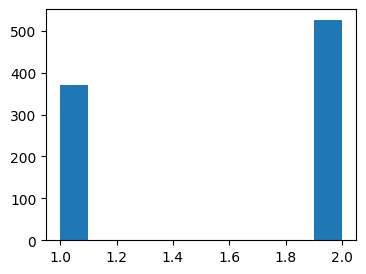

In [16]:
##### split the remaining cells into pc and pp based on argmax
# 1-pc, 2-pp
# find the argmax(sc_umi_pc_relative2, sc_umi_pp_relative2) as cell type
celltype = []
for i in range(len(df3)):
    vec_ = [df3['sc_umi_pc_relative_norm'].iloc[i], df3['sc_umi_pp_relative_norm'].iloc[i]]
    vec = np.array(vec_)
    celltype.append(np.argmax(vec)+1)

fig, ax = plt.subplots(1,1, figsize=(4,3))
n, bins, patches = plt.hist(celltype) # 1-pc, 2-pp

# 1-pc, 2-pp
df3['type'] = np.array(celltype)

df3.head()

In [17]:
##### add cell type to df
data = df.tile_cell.tolist()
keys = df3.tile_cell.tolist()
vals = df3.type.tolist()
memo = defaultdict(lambda: (-1))
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')

res11 = np.array(list(map(lambda x: memo[x], data)))

print(len(res11), len(data), len(keys), len(vals))

# append
df['type'] = np.array(res11)
# 1-pc, 2-pp, -1-npc (not classified)

df.head()

3884227 3884227 895 895


,geneID,tile,x,y,umi,cell,centerX,centerY,sc_total,sc_xmin,...,sc_xrange,sc_ymin,sc_ymax,sc_yrange,sc_umi,sc_umi_npc,sc_umi_pc,sc_umi_pp,tile_cell,type
157,Xkr4,2102,17721,19908,1,1720,17777,19511,2865,17328,...,809,19170,20021,851,1,5,16,203,2102_1720,-1
315,Xkr4,2102,16686,2244,1,1842,16808,2311,1226,16361,...,813,2100,2718,618,1,5,5,47,2102_1842,1
360,Xkr4,2102,18927,20667,1,1553,18932,20230,5703,18625,...,710,19840,20696,856,1,24,77,533,2102_1553,1
631,Xkr4,2102,19007,11672,1,1504,19294,11744,5016,18929,...,747,11340,12299,959,1,24,44,357,2102_1504,1
866,Xkr4,2102,21559,12652,1,1207,21496,12998,3848,21034,...,868,12611,13683,1072,1,8,21,262,2102_1207,-1


#### Save

In [18]:
outfile = 'output_step5/seqscope_df_dict.pkl'
# save
pickle_dict = {}
pickle_dict['df'] = df
with open(outfile, 'wb') as f:
    pickle.dump(pickle_dict, f)

# load
# with open(outfile, 'rb') as f:
#     pickle_dict = pickle.load(f)
# df = pickle_dict['df'] 

#### Visualize cells with types

In [19]:
##### define alpha colormaps
# black alpha
color_array = np.zeros([10,4])
color_array[:,-1] = np.linspace(0,1,10)
map_object = colors.LinearSegmentedColormap.from_list(name='black_alpha', colors=color_array)
plt.register_cmap(cmap=map_object)
# red alpha
color_array = np.zeros([10,4])
color_array[:,0] = 1
color_array[:,-1] = np.linspace(0,1,10)
map_object = colors.LinearSegmentedColormap.from_list(name='red_alpha', colors=color_array)
plt.register_cmap(cmap=map_object)
# green alpha
color_array = np.zeros([10,4])
color_array[:,1] = 1
color_array[:,-1] = np.linspace(0,1,10)
map_object = colors.LinearSegmentedColormap.from_list(name='green_alpha', colors=color_array)
plt.register_cmap(cmap=map_object)
# blue alpha
color_array = np.zeros([10,4])
color_array[:,1] = 1
color_array[:,2] = 1
color_array[:,-1] = np.linspace(0,1,10)
map_object = colors.LinearSegmentedColormap.from_list(name='blue_alpha', colors=color_array)
plt.register_cmap(cmap=map_object)
# pink alpha
color_array = np.zeros([10,4])
color_array[:,0] = 1
color_array[:,2] = 1
color_array[:,-1] = np.linspace(0,1,10)
map_object = colors.LinearSegmentedColormap.from_list(name='pink_alpha', colors=color_array)
plt.register_cmap(cmap=map_object)
# orange alpha
color_array = np.zeros([10,4])
color_array[:,0] = 1
color_array[:,1] = 0.39
color_array[:,2] = 0.28
color_array[:,-1] = np.linspace(0,1,10)
map_object = colors.LinearSegmentedColormap.from_list(name='orange_alpha', colors=color_array)
plt.register_cmap(cmap=map_object)

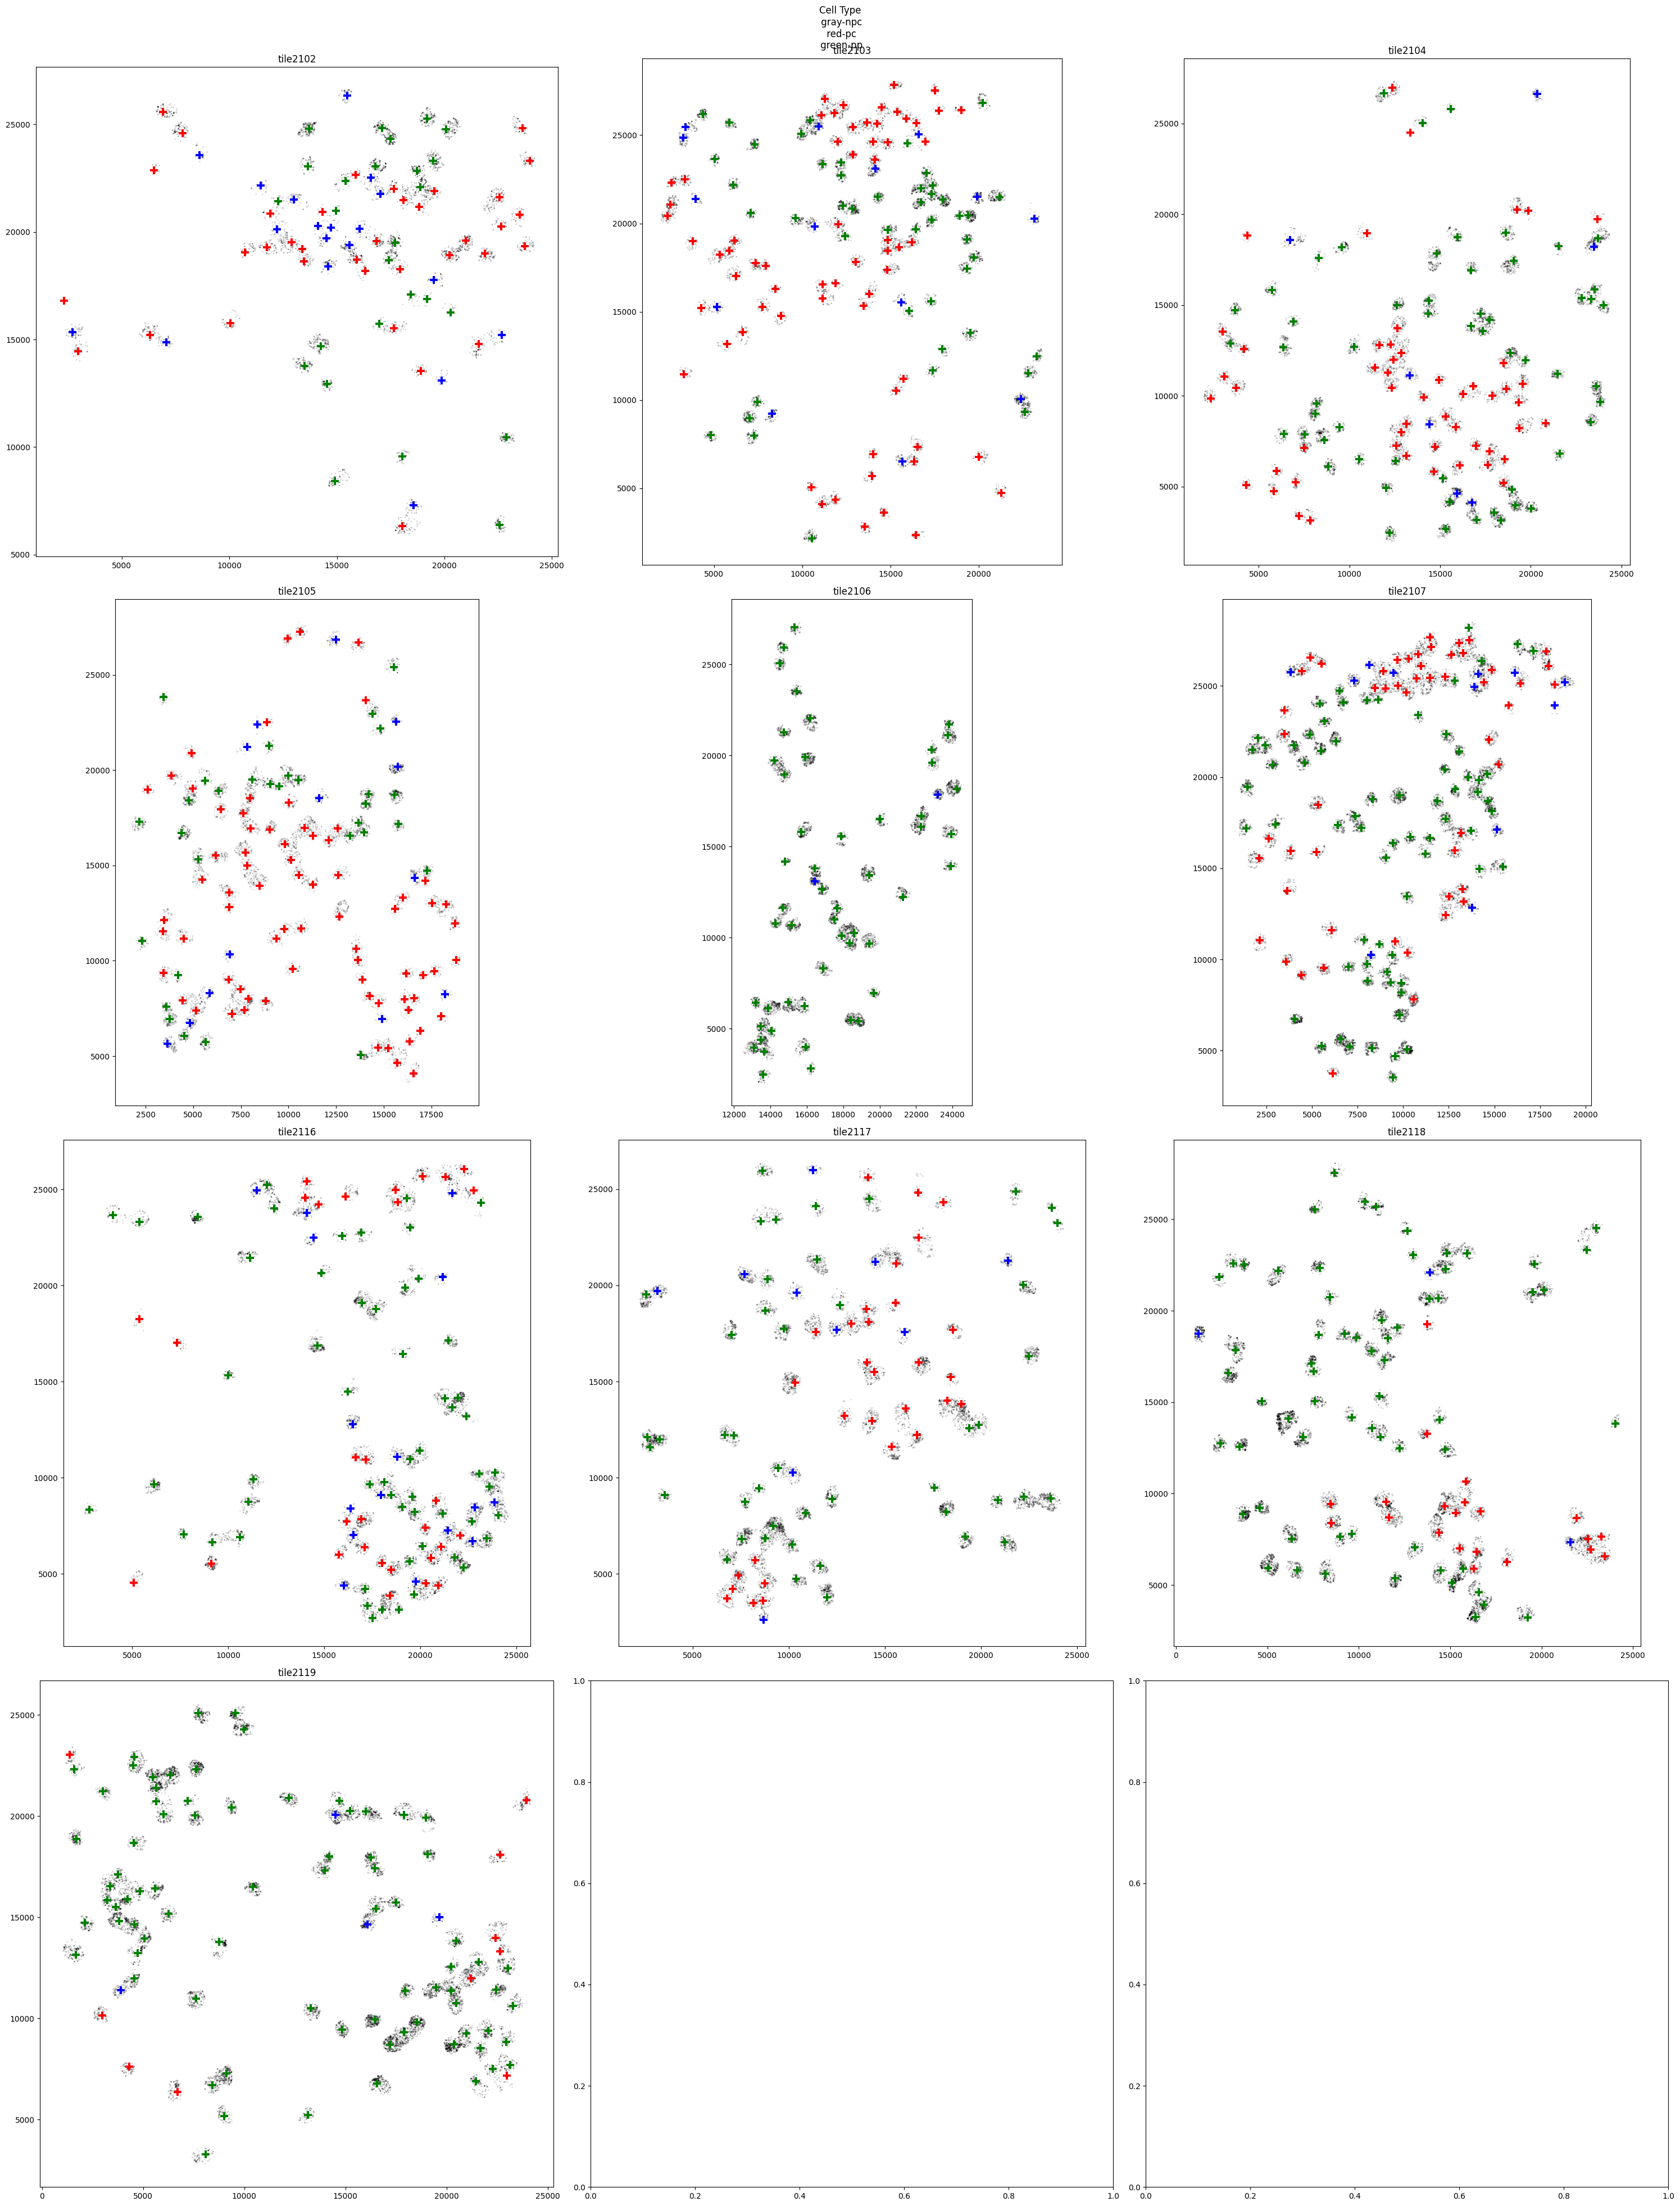

In [20]:
fig, ax = plt.subplots(4,3, figsize=(30,40))
for i, t in enumerate(tileList):

    a1 = i//3
    a2 = i%3

    df_t = df_gbT.get_group(t)

    df_g = df_t[df_t.geneID == 'Alb']
    ax[a1,a2].scatter(df_g.y, 
               df_g.x,
               c=df_g.umi,
               s=1,
               cmap='black_alpha')

    type_ = df_t.type.to_numpy()
    # npc - gray
    ax[a1,a2].scatter(df_t.centerY.to_numpy()[type_==-1],
               df_t.centerX.to_numpy()[type_==-1],
               c = 'blue',
               marker='+', 
               s=100)
    # pc - red
    ax[a1,a2].scatter(df_t.centerY.to_numpy()[type_==1],
               df_t.centerX.to_numpy()[type_==1],
               c = 'red',
               marker='+', 
               s=100)
    # pp - green
    ax[a1,a2].scatter(df_t.centerY.to_numpy()[type_==2],
               df_t.centerX.to_numpy()[type_==2],
               c = 'green',
               marker='+', 
               s=100)
    
    ax[a1,a2].set_aspect('equal', adjustable='box')
    ax[a1,a2].grid(False)
    ax[a1,a2].set_title('tile'+str(t))
    
plt.suptitle('Cell Type\n gray-npc\n red-pc\n green-pp\n\n')
plt.tight_layout()
fig.savefig('output_fig/step5_celltype.pdf', dpi=300)